<a href="https://colab.research.google.com/github/LouisBay/manduin-apps/blob/machine-learning/Landmark_Classification(Transfer_Learning).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Library

In [1]:
import tensorflow as tf
print('TensorFlow :', tf.__version__)

TensorFlow : 2.8.0


In [2]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.xception import preprocess_input
from keras_preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.optimizers import Adam
from keras.preprocessing import image
from tensorflow.keras import layers
from tensorflow.keras import Model
import tensorflow as tf

import os, shutil, zipfile
import string
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from google.colab import files
import random
from shutil import copyfile



## Create Main Directory, Download, & Extract Dataset

In [3]:

BASE_DIR = '/content'
os.chdir(BASE_DIR)


In [4]:
# Download the datasets
dataset_zip_path = os.path.join(BASE_DIR, 'Bangkit-Capstone-Dataset-main.zip')
if not os.path.exists(dataset_zip_path):
  !wget --no-check-certificate --content-disposition https://codeload.github.com/mrsambaga/Bangkit-Capstone-Dataset/zip/refs/heads/main
else:
  print("Dataset already downloaded")

--2022-05-28 14:57:53--  https://codeload.github.com/mrsambaga/Bangkit-Capstone-Dataset/zip/refs/heads/main
Resolving codeload.github.com (codeload.github.com)... 140.82.114.9
Connecting to codeload.github.com (codeload.github.com)|140.82.114.9|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘Bangkit-Capstone-Dataset-main.zip’

Bangkit-Capstone-Da     [             <=>    ] 263.63M  22.9MB/s    in 11s     

2022-05-28 14:58:05 (23.3 MB/s) - ‘Bangkit-Capstone-Dataset-main.zip’ saved [276436382]



In [5]:
dataset_main_dir = os.path.join(BASE_DIR, 'dataset')
if os.path.exists(dataset_main_dir):
  shutil.rmtree(dataset_main_dir)

os.makedirs(dataset_main_dir)

with zipfile.ZipFile(dataset_zip_path, 'r') as zip_ref:
  zip_ref.extractall(dataset_main_dir)

In [6]:
branch = 'Bangkit-Capstone-Dataset-main/dataset/'
dataset_dir = os.path.join(dataset_main_dir, branch)

for dir in os.listdir(dataset_dir):
  class_dir = os.path.join(dataset_dir, dir)
  print('total images for', dir, 'is', len(os.listdir(class_dir)))

total images for besakih is 200
total images for suroboyo is 216
total images for monas is 146
total images for gedungsate is 140
total images for lawangsewu is 115
total images for prambanan is 194
total images for jamgadang is 115
total images for borobudur is 131
total images for sampookong is 148
total images for tamanayun is 130
total images for tugujogja is 100
total images for gwk is 100
total images for majt is 111
total images for museumfatahillah is 134
total images for monjali is 88


#Create Dataset Directory & Split Data to Train, Validation, & Test

In [7]:
branch = 'Bangkit-Capstone-Dataset-main/dataset_split'
dataset_split_dir = os.path.join(dataset_main_dir, branch)

if os.path.exists(dataset_split_dir):
  shutil.rmtree(dataset_split_dir)

def create_train_test_dirs(root_path):

  os.makedirs(os.path.join(root_path, 'training'))
  os.makedirs(os.path.join(root_path, 'validation'))
  os.makedirs(os.path.join(root_path, 'testing'))

  train_dir = os.path.join(root_path, "training")
  validation_dir = os.path.join(root_path, "validation")
  test_dir = os.path.join(root_path, "testing")

  for dir in os.listdir(dataset_dir):
    os.makedirs(os.path.join(train_dir, dir))

  for dir in os.listdir(dataset_dir):
    os.makedirs(os.path.join(validation_dir, dir))
  
  for dir in os.listdir(dataset_dir):
    os.makedirs(os.path.join(test_dir, dir))
  
try:
  create_train_test_dirs(root_path=dataset_split_dir)
except FileExistsError:
  print("You should not be seeing this since the upper directory is removed beforehand")

In [8]:
for rootdir, dirs, files in os.walk(dataset_split_dir):
    for subdir in dirs:
        print(os.path.join(dataset_split_dir, subdir))

/content/dataset/Bangkit-Capstone-Dataset-main/dataset_split/validation
/content/dataset/Bangkit-Capstone-Dataset-main/dataset_split/testing
/content/dataset/Bangkit-Capstone-Dataset-main/dataset_split/training
/content/dataset/Bangkit-Capstone-Dataset-main/dataset_split/besakih
/content/dataset/Bangkit-Capstone-Dataset-main/dataset_split/suroboyo
/content/dataset/Bangkit-Capstone-Dataset-main/dataset_split/monas
/content/dataset/Bangkit-Capstone-Dataset-main/dataset_split/gedungsate
/content/dataset/Bangkit-Capstone-Dataset-main/dataset_split/lawangsewu
/content/dataset/Bangkit-Capstone-Dataset-main/dataset_split/prambanan
/content/dataset/Bangkit-Capstone-Dataset-main/dataset_split/jamgadang
/content/dataset/Bangkit-Capstone-Dataset-main/dataset_split/borobudur
/content/dataset/Bangkit-Capstone-Dataset-main/dataset_split/sampookong
/content/dataset/Bangkit-Capstone-Dataset-main/dataset_split/tamanayun
/content/dataset/Bangkit-Capstone-Dataset-main/dataset_split/tugujogja
/content/dat

In [9]:
def split_data(SOURCE, TRAINING, VALIDATION, TESTING, SPLIT_SIZE):

  source = os.listdir(SOURCE)
  file_number = len(source)

  for file in source:
    if os.path.getsize(SOURCE+file) == 0:
      print("{} is zero length, so ignoring.".format(file))
      source.remove(file)

  random.sample(source, len(source))

  for index, file in enumerate(source): 
    if index < SPLIT_SIZE * file_number: 
      if index < 0.8 * file_number:
        copyfile(os.path.join(SOURCE, file), os.path.join(TRAINING, file))
      else:
        copyfile(os.path.join(SOURCE, file), os.path.join(VALIDATION, file))
    else: 
        copyfile(os.path.join(SOURCE, file), os.path.join(TESTING, file)) 

In [10]:
#Source directory
BOROBUDUR_SOURCE_DIR = os.path.join(dataset_dir, 'borobudur/')
LAWANGSEWU_SOURCE_DIR = os.path.join(dataset_dir, 'lawangsewu/')
MAJT_SOURCE_DIR = os.path.join(dataset_dir, 'majt/')
MONJALI_SOURCE_DIR = os.path.join(dataset_dir, 'monjali/')
PRAMBANAN_SOURCE_DIR = os.path.join(dataset_dir, 'prambanan/')
TUGUJOGJA_SOURCE_DIR = os.path.join(dataset_dir, 'tugujogja/')
GWK_SOURCE_DIR = os.path.join(dataset_dir, 'gwk/')
BESAKIH_SOURCE_DIR = os.path.join(dataset_dir, 'besakih/')
JAMGADANG_SOURCE_DIR = os.path.join(dataset_dir, 'jamgadang/')
SUROBOYO_SOURCE_DIR = os.path.join(dataset_dir, 'suroboyo/')
GEDUNGSATE_SOURCE_DIR = os.path.join(dataset_dir, 'gedungsate/')
SAMPOOKONG_SOURCE_DIR = os.path.join(dataset_dir, 'sampookong/')
TAMANAYUN_SOURCE_DIR = os.path.join(dataset_dir, 'tamanayun/')
FATAHILLAH_SOURCE_DIR = os.path.join(dataset_dir, 'museumfatahillah/')
MONAS_SOURCE_DIR = os.path.join(dataset_dir, 'monas/')

TRAINING_DIR = os.path.join(dataset_split_dir, "training/")
TESTING_DIR = os.path.join(dataset_split_dir, "testing/")
VALIDATION_DIR = os.path.join(dataset_split_dir, "validation/")

#Training Directory
BOROBUDUR_TRAINING_DIR = os.path.join(TRAINING_DIR, "borobudur/")
LAWANGSEWU_TRAINING_DIR = os.path.join(TRAINING_DIR, "lawangsewu/")
MAJT_TRAINING_DIR = os.path.join(TRAINING_DIR, "majt/")
MONJALI_TRAINING_DIR = os.path.join(TRAINING_DIR, "monjali/")
PRAMBANAN_TRAINING_DIR = os.path.join(TRAINING_DIR, "prambanan/")
TUGUJOGJA_TRAINING_DIR = os.path.join(TRAINING_DIR, "tugujogja/")
GWK_TRAINING_DIR = os.path.join(TRAINING_DIR, 'gwk/')
BESAKIH_TRAINING_DIR = os.path.join(TRAINING_DIR, 'besakih/')
JAMGADANG_TRAINING_DIR = os.path.join(TRAINING_DIR, 'jamgadang/')
SUROBOYO_TRAINING_DIR = os.path.join(TRAINING_DIR, 'suroboyo/')
GEDUNGSATE_TRAINING_DIR = os.path.join(TRAINING_DIR, 'gedungsate/')
SAMPOOKONG_TRAINING_DIR = os.path.join(TRAINING_DIR, 'sampookong/')
TAMANAYUN_TRAINING_DIR = os.path.join(TRAINING_DIR, 'tamanayun/')
FATAHILLAH_TRAINING_DIR = os.path.join(TRAINING_DIR, 'museumfatahillah/')
MONAS_TRAINING_DIR = os.path.join(TRAINING_DIR, 'monas/')

#Validation Directory
BOROBUDUR_VALIDATION_DIR = os.path.join(VALIDATION_DIR, "borobudur/")
LAWANGSEWU_VALIDATION_DIR = os.path.join(VALIDATION_DIR, "lawangsewu/")
MAJT_VALIDATION_DIR = os.path.join(VALIDATION_DIR, "majt/")
MONJALI_VALIDATION_DIR = os.path.join(VALIDATION_DIR, "monjali/")
PRAMBANAN_VALIDATION_DIR = os.path.join(VALIDATION_DIR, "prambanan/")
TUGUJOGJA_VALIDATION_DIR = os.path.join(VALIDATION_DIR, "tugujogja/")
GWK_VALIDATION_DIR = os.path.join(VALIDATION_DIR, 'gwk/')
BESAKIH_VALIDATION_DIR = os.path.join(VALIDATION_DIR, 'besakih/')
JAMGADANG_VALIDATION_DIR = os.path.join(VALIDATION_DIR, 'jamgadang/')
SUROBOYO_VALIDATION_DIR = os.path.join(VALIDATION_DIR, 'suroboyo/')
GEDUNGSATE_VALIDATION_DIR = os.path.join(VALIDATION_DIR, 'gedungsate/')
SAMPOOKONG_VALIDATION_DIR = os.path.join(VALIDATION_DIR, 'sampookong/')
TAMANAYUN_VALIDATION_DIR = os.path.join(VALIDATION_DIR, 'tamanayun/')
FATAHILLAH_VALIDATION_DIR = os.path.join(VALIDATION_DIR, 'museumfatahillah/')
MONAS_VALIDATION_DIR = os.path.join(VALIDATION_DIR, 'monas/')

#Testing Directory
BOROBUDUR_TESTING_DIR = os.path.join(TESTING_DIR, "borobudur/")
LAWANGSEWU_TESTING_DIR = os.path.join(TESTING_DIR, "lawangsewu/")
MAJT_TESTING_DIR = os.path.join(TESTING_DIR, "majt/")
MONJALI_TESTING_DIR = os.path.join(TESTING_DIR, "monjali/")
PRAMBANAN_TESTING_DIR = os.path.join(TESTING_DIR, "prambanan/")
TUGUJOGJA_TESTING_DIR = os.path.join(TESTING_DIR, "tugujogja/")
GWK_TESTING_DIR = os.path.join(TESTING_DIR, 'gwk/')
BESAKIH_TESTING_DIR = os.path.join(TESTING_DIR, 'besakih/')
JAMGADANG_TESTING_DIR = os.path.join(TESTING_DIR, 'jamgadang/')
SUROBOYO_TESTING_DIR = os.path.join(TESTING_DIR, 'suroboyo/')
GEDUNGSATE_TESTING_DIR = os.path.join(TESTING_DIR, 'gedungsate/')
SAMPOOKONG_TESTING_DIR = os.path.join(TESTING_DIR, 'sampookong/')
TAMANAYUN_TESTING_DIR = os.path.join(TESTING_DIR, 'tamanayun/')
FATAHILLAH_TESTING_DIR = os.path.join(TESTING_DIR, 'museumfatahillah/')
MONAS_TESTING_DIR = os.path.join(TESTING_DIR, 'monas/')

# Define proportion of images used for training
split_size = .95

# Run the function
# NOTE: Messages about zero length images should be printed out
split_data(BOROBUDUR_SOURCE_DIR, BOROBUDUR_TRAINING_DIR, BOROBUDUR_VALIDATION_DIR, BOROBUDUR_TESTING_DIR, split_size)
split_data(LAWANGSEWU_SOURCE_DIR, LAWANGSEWU_TRAINING_DIR, LAWANGSEWU_VALIDATION_DIR, LAWANGSEWU_TESTING_DIR, split_size)
split_data(MONJALI_SOURCE_DIR, MONJALI_TRAINING_DIR, MONJALI_VALIDATION_DIR, MONJALI_TESTING_DIR, split_size)
split_data(MAJT_SOURCE_DIR, MAJT_TRAINING_DIR, MAJT_VALIDATION_DIR, MAJT_TESTING_DIR, split_size)
split_data(PRAMBANAN_SOURCE_DIR, PRAMBANAN_TRAINING_DIR, PRAMBANAN_VALIDATION_DIR, PRAMBANAN_TESTING_DIR, split_size)
split_data(TUGUJOGJA_SOURCE_DIR, TUGUJOGJA_TRAINING_DIR, TUGUJOGJA_VALIDATION_DIR, TUGUJOGJA_TESTING_DIR, split_size)
split_data(GWK_SOURCE_DIR, GWK_TRAINING_DIR, GWK_VALIDATION_DIR, GWK_TESTING_DIR, split_size)
split_data(BESAKIH_SOURCE_DIR, BESAKIH_TRAINING_DIR, BESAKIH_VALIDATION_DIR, BESAKIH_TESTING_DIR, split_size)
split_data(JAMGADANG_SOURCE_DIR, JAMGADANG_TRAINING_DIR, JAMGADANG_VALIDATION_DIR, JAMGADANG_TESTING_DIR, split_size)
split_data(SUROBOYO_SOURCE_DIR, SUROBOYO_TRAINING_DIR, SUROBOYO_VALIDATION_DIR, SUROBOYO_TESTING_DIR, split_size)
split_data(GEDUNGSATE_SOURCE_DIR, GEDUNGSATE_TRAINING_DIR, GEDUNGSATE_VALIDATION_DIR, GEDUNGSATE_TESTING_DIR, split_size)
split_data(SAMPOOKONG_SOURCE_DIR, SAMPOOKONG_TRAINING_DIR, SAMPOOKONG_VALIDATION_DIR, SAMPOOKONG_TESTING_DIR, split_size)
split_data(TAMANAYUN_SOURCE_DIR, TAMANAYUN_TRAINING_DIR, TAMANAYUN_VALIDATION_DIR, TAMANAYUN_TESTING_DIR, split_size)
split_data(FATAHILLAH_SOURCE_DIR, FATAHILLAH_TRAINING_DIR, FATAHILLAH_VALIDATION_DIR, FATAHILLAH_TESTING_DIR, split_size)
split_data(MONAS_SOURCE_DIR, MONAS_TRAINING_DIR, MONAS_VALIDATION_DIR, MONAS_TESTING_DIR, split_size)

# Check that the number of images matches the expected output



In [11]:
for dir in os.listdir(TRAINING_DIR):
  print(f"There are {len(os.listdir(os.path.join(TRAINING_DIR, dir)))} images in " + dir + " for training")

print("\n")

for dir in os.listdir(VALIDATION_DIR):
  print(f"There are {len(os.listdir(os.path.join(VALIDATION_DIR, dir)))} images in " + dir + " for validation")

print("\n")

for dir in os.listdir(TESTING_DIR):
  print(f"There are {len(os.listdir(os.path.join(TESTING_DIR, dir)))} images in " + dir + " for testing")

There are 160 images in besakih for training
There are 173 images in suroboyo for training
There are 117 images in monas for training
There are 112 images in gedungsate for training
There are 92 images in lawangsewu for training
There are 156 images in prambanan for training
There are 92 images in jamgadang for training
There are 105 images in borobudur for training
There are 119 images in sampookong for training
There are 104 images in tamanayun for training
There are 80 images in tugujogja for training
There are 80 images in gwk for training
There are 89 images in majt for training
There are 108 images in museumfatahillah for training
There are 71 images in monjali for training


There are 30 images in besakih for validation
There are 33 images in suroboyo for validation
There are 22 images in monas for validation
There are 21 images in gedungsate for validation
There are 18 images in lawangsewu for validation
There are 29 images in prambanan for validation
There are 18 images in jam

#Data Preprocessing with TF ImageDataGenerator

In [12]:
def train_val_generators(TRAINING_DIR, VALIDATION_DIR, TESTING_DIR):

  # Instantiate the ImageDataGenerator class
  train_datagen = ImageDataGenerator(rescale=1.0/255,
                                     rotation_range=10,
                                     width_shift_range=0.2,
                                     height_shift_range=0.2,
                                     shear_range=0.2,
                                     zoom_range=0.2,
                                     horizontal_flip=True,
                                     fill_mode='nearest')

  train_generator = train_datagen.flow_from_directory(directory=TRAINING_DIR,
                                                      batch_size=32,
                                                      class_mode='categorical',
                                                      target_size=(224, 224))

  validation_datagen = ImageDataGenerator( rescale = 1.0/255. )

  validation_generator = validation_datagen.flow_from_directory(directory=VALIDATION_DIR,
                                                                batch_size=32,
                                                                class_mode='categorical',
                                                                target_size=(224, 224))

  testing_datagen = ImageDataGenerator( rescale = 1.0/255. )

  testing_generator = validation_datagen.flow_from_directory(directory=TESTING_DIR,
                                                                batch_size=32,
                                                                class_mode='categorical',
                                                                target_size=(224, 224))
  

  return train_generator, validation_generator, testing_generator

In [13]:
# Test your generators
train_generator, validation_generator, testing_generator = train_val_generators(TRAINING_DIR, VALIDATION_DIR, TESTING_DIR)

Found 1658 images belonging to 15 classes.
Found 313 images belonging to 15 classes.
Found 96 images belonging to 15 classes.


In [14]:
train_dataset = image_dataset_from_directory(TRAINING_DIR,
                                             shuffle=True,
                                             batch_size=34,
                                             image_size=(224,224))

class_names = train_dataset.class_names

Found 1658 files belonging to 15 classes.


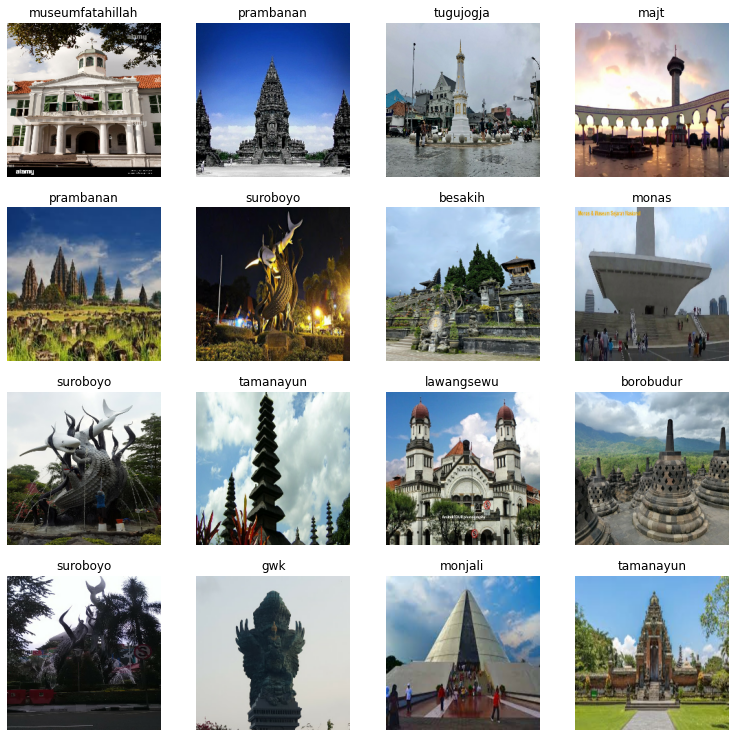

In [15]:
plt.figure(figsize=(13, 13))
for images, labels in train_dataset.take(1):
  for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

# TF Image Classification Model with Transfer Learning

In [16]:
pretrained_model = InceptionV3(input_shape = (224, 224, 3),
                                include_top = False,
                                weights = 'imagenet')

for layer in pretrained_model.layers:
    layer.trainable = False 

87924736/87910968 [==============================] - 1s 0us/step


In [17]:
total_params = pretrained_model.count_params()
num_trainable_params = sum([w.shape.num_elements() for w in pretrained_model.trainable_weights])

print(f"There are {total_params:,} total parameters in this model.")
print(f"There are {num_trainable_params:,} trainable parameters in this model.")

There are 21,802,784 total parameters in this model.
There are 0 trainable parameters in this model.


In [18]:
last_desired_layer = pretrained_model.get_layer('mixed7')
print('last layer output shape: ', last_desired_layer.output_shape)
last_output = last_desired_layer.output
print('last layer output: ', last_output) 

last layer output shape:  (None, 12, 12, 768)
last layer output:  KerasTensor(type_spec=TensorSpec(shape=(None, 12, 12, 768), dtype=tf.float32, name=None), name='mixed7/concat:0', description="created by layer 'mixed7'")


In [19]:
  x = layers.Flatten()(last_output)
  x = layers.Dense(512, activation='relu')(x)
  x = layers.Dropout(0.4)(x) 
  x = layers.Dense(15, activation='softmax')(x)        

  # Create the complete model by using the Model class
  model = Model(pretrained_model.input, x)

In [20]:
#Compile model
model.compile(loss = 'categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(0.0003), metrics=['accuracy'])

In [21]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 111, 111, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 111, 111, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                             

## Fit Model

In [ ]:
history = model.fit(
  train_generator,
  epochs=25,
  verbose=1,
  validation_data=validation_generator
)

Epoch 1/25
 9/52 [====>.........................] - ETA: 22s - loss: 3.6575 - accuracy: 0.2049

## Plot Train & Val Accuracy

In [ ]:
import matplotlib.pyplot as plt

# Plot the results
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
loss = model.evaluate(testing_generator, steps=10)

#Predicting Image

In [ ]:
classes = train_generator.class_indices 
print(classes)

In [ ]:
labels = train_generator.class_indices.keys()

for folder in os.listdir(TESTING_DIR):
    for file_name in os.listdir(os.path.join(TESTING_DIR, folder)):

      file_dir = folder + "/" + file_name

      # predicting images
      path = os.path.join(TESTING_DIR, file_dir)
      img = image.load_img(path, target_size=(224, 224))
      x = image.img_to_array(img)
      x = np.expand_dims(x, axis=0)
      x = preprocess_input(x)

      images = np.vstack([x])
      classes = model.predict(images, batch_size=10)
      proba = model.predict(images)[0]

      for (label, p) in zip(labels, proba):
        if p*100 > 60 :
          print("Predicted : {} ({:.2f}%)".format(label, p * 100))
      plt.imshow(img)
      plt.axis("off")
      plt.show()
      

#Exporting Model

In [ ]:
export_dir = 'saved_model/1'
tf.saved_model.save(model, export_dir)

In [ ]:
converter = tf.lite.TFLiteConverter.from_saved_model(export_dir)
converter.optimizations = [tf.lite.Optimize.OPTIMIZE_FOR_SIZE]
tflite_model = converter.convert()


In [ ]:
tflite_model_file = 'converted_model.tflite'

with open(tflite_model_file, "wb") as f:
    f.write(tflite_model)

In [ ]:
with open('labels.txt', 'w') as f:
    f.write('\n'.join(class_names))

In [ ]:
try:
    from google.colab import files
    files.download('converted_model.tflite')
    files.download('labels.txt')
except:
    pass